# 3. Random Forests Classifier

On this notebook we focus on training the classifier and show the performance of the model.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import random

import seaborn as sns


from sklearn.cross_validation import StratifiedShuffleSplit

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import LabelEncoder

from matplotlib import cm as cmap

import pylab


We take the labeled data we have created in the notebook "2.Development"

In [129]:
nyc_data = pd.read_csv('labeled_data_yellow_tripdata_2015-06.csv', skipinitialspace=True)
print "Number of trips registered: ", len(nyc_data)

Number of trips registered:  7278117


Initially, we consider splitting the data and perform training and testing separately. However, we took advantage of the croos validation technique and then we have only set up the quantity of information we want to be part of the testing data. Just omit this following line for this time.

In [4]:
"""
training_size = 0.7
optimisation_size = 0.2
testing_size = 0.1

n_training = int(round(len(nyc_data)*training_size))
n_optimisation = int(round(len(nyc_data)*optimisation_size)) + n_training

training_data = nyc_data[0:n_training]
optimisation_data = nyc_data[n_training: n_optimisation]
testing_data = nyc_data[n_optimisation:]
"""


As mentioned in the notebook 2.Development, we consider the following 13 features to train the random forests classifier.

In [134]:
feature_names = [ 'passenger_count',
                  'trip_distance_label',
                  'pickup_longitude',
                  'pickup_latitude',
                  'dropoff_longitude',
                  'dropoff_latitude',
                  'RateCodeID',
                  'trip_time_label',
                  'day_ofweek',
                  'hour_label',
                  'fare_amount_label',
                  'extra',
                  'tip_label_total']
nyc_features, nyc_y = nyc_data[feature_names].values, nyc_data['tip_label_fare'].values

It is time to proceed with the training step of the classifier. 

We use 10-fold cross validation and 25 trees to construct a robuts classifier

This part of the code and some other ideas were taken and adapted from https://github.com/josemazo/nyc-taxi-tip-predictor/.


In [135]:
cross_validation = StratifiedShuffleSplit(nyc_y, n_iter=10, test_size=0.3, random_state=0)

scores = []
confusion_matrices = []
rf_models = []

for train_index,test_index in cross_validation:

    clf = None

    data_features_train, data_classes_train = nyc_features[train_index], nyc_y[train_index]
    data_features_test, data_classes_test = nyc_features[test_index], nyc_y[test_index]

    clf = RandomForestClassifier(n_estimators= 25, n_jobs=-1)
    clf.fit(data_features_train, data_classes_train)
    rf_models.append(clf)
    # Saving the scores.
    test_score = clf.score(data_features_test, data_classes_test)
    scores.append(test_score)

    # Saving the confusion matrices.
    data_classes_pred = clf.predict(data_features_test)
    cm = confusion_matrix(data_classes_test, data_classes_pred)
    confusion_matrices.append(cm)
        


print 'Accuracy mean: ' + str(np.mean(scores))
print 'Accuracy std: ' + str(np.std(scores))   

Accuracy mean: 0.865685186101
Accuracy std: 0.000200027607188


The accuracy of our model is quite good! More than 85% of accuracy on average. Let's see the importance of each feature considered to get this performance.

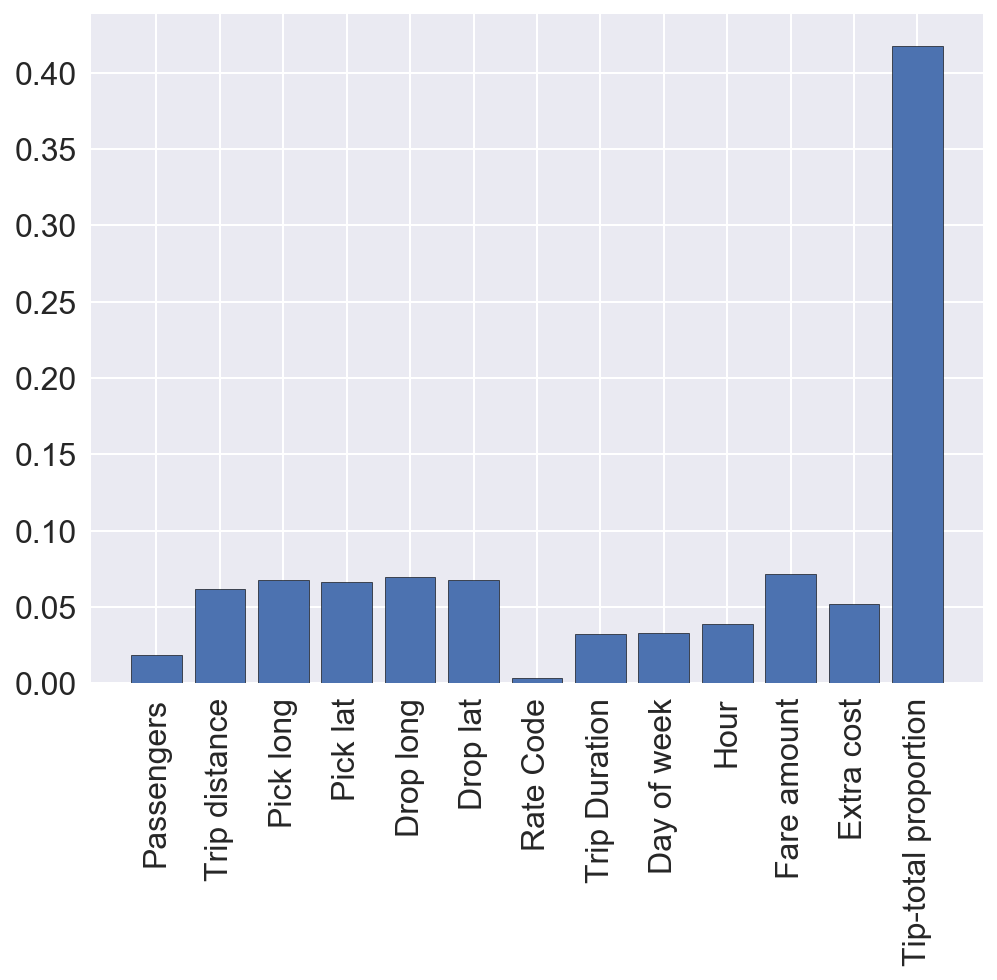

In [130]:
features = clf.feature_importances_
feature_names = ['Passengers','Trip distance','Pick long','Pick lat','Drop long', 'Drop lat','Rate Code', 'Trip Duration', 'Day of week','Hour', 'Fare amount','Extra cost', 'Tip-total proportion']


pylab.figure(1,figsize=(8,6))
x = range(13)
pylab.xticks(x, feature_names,fontsize=16,rotation='vertical')

pylab.yticks(fontsize=16)
pylab.bar(x,features,align="center")
pylab.show()


It is clear that tip-total proportion is a key factor to get this performance. When this variable is not considered the performance of our model decreases up to 40%! Appart from this attribute most of the variables seem to have an important relevance for predicting the tip amounts desired.

Considering only a million trips we tried diverse random forests classifiers with different number of trees. We can see that after 50 trees the complexity of the classifier increases dramatically but the performance does not have substantial improvementes. For this reason, we consider an optimal classifier can be set between 20 to less than 50 trees. We consider using 25 trees to construct the model we have described previously.

Text(0.5,0,u'Number of trees')

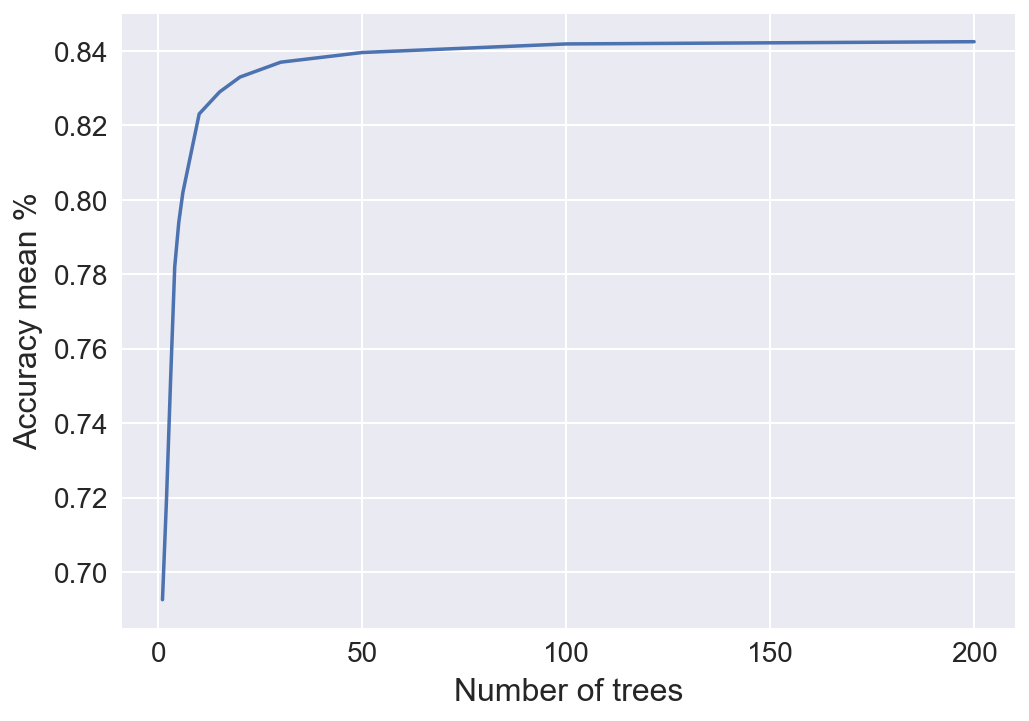

In [71]:
plt.plot(trees,means)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Accuracy mean %',fontsize= 16)
plt.xlabel('Number of trees',fontsize= 16)
plt.title('Accuracy of trees when training Random Forest Classifier', fontsize = 16)

Then it is time to analyse the confusion matrix. We can see that the predictions performed in most of the classes have good accuracy. The model has proven to perform well when trips paid tip amounts from 10% to 30% of the fare amount. This is because most of the information provided to the model is concentrated in this area. Therefore, we can notice that the model has learned competitively these classes. On the other side, the less popular classes are difficult for the classifier to predict the tip amount that would be paid to its corresponding trip.

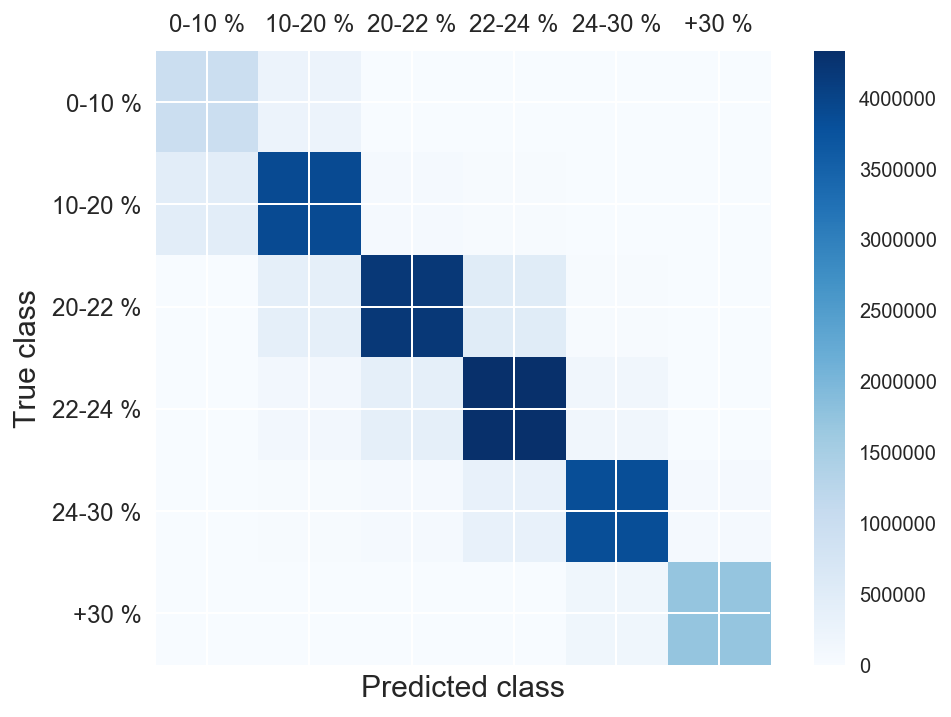

In [136]:
tip_labels = ['0-10 %' , '10-20 %', '20-22 %', '22-24 %', '24-30 %', '+30 %']


first = True
cm = None

for cm_iter in confusion_matrices:
    if first:
        cm = cm_iter.copy()
        first = False
    else:
        cm = cm + cm_iter

fig, axes = plt.subplots()

colorbar = axes.matshow(cm, cmap=cmap.Blues)
fig.colorbar(colorbar)

axes.set_xlabel('Predicted class', fontsize=15)
axes.set_ylabel('True class', fontsize=15)

axes.set_xticklabels(tip_labels)
axes.set_yticklabels(tip_labels)

axes.tick_params(labelsize=12)